### Question 8:
At first we import required libraries.

In [146]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn import mixture
from matplotlib.patches import Ellipse

Now we read the csv file containing data.

In [16]:
data = pd.read_csv('penguins.csv')

The next step is to inspect data using head describe and info.

In [17]:
data.head(10)

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE
6,Adelie,Torgersen,38.9,17.8,181.0,3625.0,FEMALE
7,Adelie,Torgersen,39.2,19.6,195.0,4675.0,MALE
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
species              344 non-null object
island               344 non-null object
culmen_length_mm     342 non-null float64
culmen_depth_mm      342 non-null float64
flipper_length_mm    342 non-null float64
body_mass_g          342 non-null float64
sex                  334 non-null object
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [19]:
data.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


The next step is to fill nan values of columns.

In [20]:
data.isnull().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

Let's check th distribution of penguins by their species.

In [23]:
data.species.value_counts()

Adelie       152
Gentoo       124
Chinstrap     68
Name: species, dtype: int64

In [24]:
data.sex.value_counts()

MALE      168
FEMALE    165
.           1
Name: sex, dtype: int64

Now I fill the nan values with mean of each class.

In [25]:
data['culmen_length_mm'] = data['culmen_length_mm'].fillna(data.groupby('species')['culmen_length_mm'].transform('mean'))
data['culmen_depth_mm'] = data['culmen_depth_mm'].fillna(data.groupby('species')['culmen_depth_mm'].transform('mean'))
data['flipper_length_mm'] = data['flipper_length_mm'].fillna(data.groupby('species')['flipper_length_mm'].transform('mean'))
data['body_mass_g'] = data['body_mass_g'].fillna(data.groupby('species')['body_mass_g'].transform('mean'))

Now I fill the nan values of categorical feature with unknown although it was not necessary since this feature will not be used at all.

In [26]:
data["sex"] = data["sex"].fillna("Unknown")

It is obvious that after last steps, there is not any nan values in dataframe.

In [28]:
data.isnull().sum()

species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

Now we plot scatterplot of dataset regarding 2 features each time. The color of each class is eclectic. It can be determined from these scatterpots that the first two pair of features, discriminate our data better(Second one seems to be the best one). In these two scatterplots, densities of classes are discriminate from each other and you can visually draw borders between them.

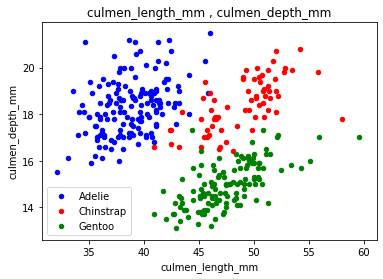

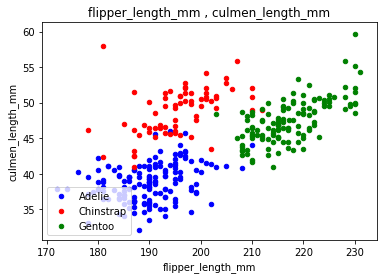

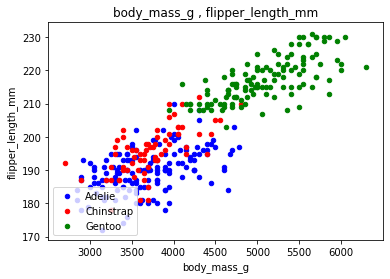

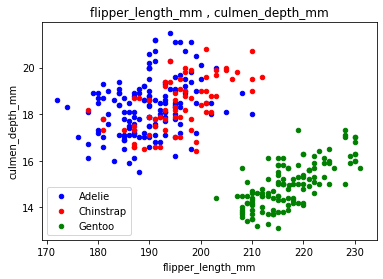

In [67]:
for first, second in zip(['culmen_length_mm', 'flipper_length_mm', 'body_mass_g', 'flipper_length_mm']
                         ,['culmen_depth_mm', 'culmen_length_mm', 'flipper_length_mm', 'culmen_depth_mm']):
    fig, ax = plt.subplots()
    for color, label in zip(['blue', 'red', 'green'], ['Adelie', 'Chinstrap', 'Gentoo']):
        x = data.loc[data.species == label][first]
        y = data.loc[data.species == label][second]
        ax.scatter(x, y, c=color, s=20, label=label)
    plt.xlabel(first)
    plt.ylabel(second)
    plt.title(first + ' , ' + second)
    ax.legend(loc="lower left")
    plt.show()

In this step i defined a function in order to draw contours of GMM.

In [143]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

As requested in question, I fit GMM models with 1 component for each class and for each pair of features. As we saw in the last part, the first 2 pairs are better than others. Also contours of the second pair are more diverse than the first one so a model based on the second pair would have less error than the first one. Also the centeral contours for each class in the second plot, encompass more datapoints than the first plot.

Means:  [[38.79139073 18.34635762]] Covariances:  [[[7.00038789 1.25190964]
  [1.25190964 1.46076085]]] Weights:  [1.]
Means:  [[48.83382353 18.42058824]] Covariances:  [[[10.98665109  2.44136246]
  [ 2.44136246  1.27016536]]] Weights:  [1.]
Means:  [[47.50487805 14.98211382]] Covariances:  [[[9.34465482 1.91419945]
  [1.91419945 0.94726431]]] Weights:  [1.]


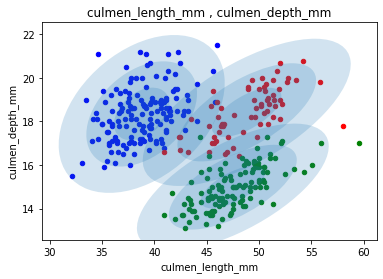

Means:  [[189.95364238  38.79139073]] Covariances:  [[[42.20181348  5.59960352]
  [ 5.59960352  7.00038789]]] Weights:  [1.]
Means:  [[195.82352941  48.83382353]] Covariances:  [[[50.11591796 11.06626298]
  [11.06626298 10.98665109]]] Weights:  [1.]
Means:  [[217.18699187  47.50487805]] Covariances:  [[[41.37660735 13.0007081 ]
  [13.0007081   9.34465482]]] Weights:  [1.]


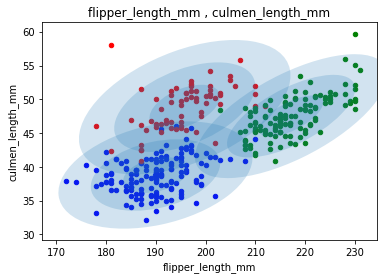

Means:  [[3700.66225166  189.95364238]] Covariances:  [[[2.07516012e+05 1.38555681e+03]
  [1.38555681e+03 4.22018135e+01]]] Weights:  [1.]
Means:  [[3733.08823529  195.82352941]] Covariances:  [[[1.45541198e+05 1.73267734e+03]
  [1.73267734e+03 5.01159180e+01]]] Weights:  [1.]
Means:  [[5076.01626016  217.18699187]] Covariances:  [[[2.50034258e+05 2.26009376e+03]
  [2.26009376e+03 4.13766073e+01]]] Weights:  [1.]


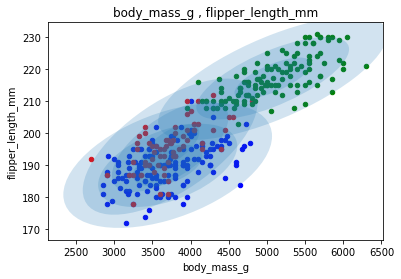

Means:  [[189.95364238  18.34635762]] Covariances:  [[[42.20181348  2.41529278]
  [ 2.41529278  1.46076085]]] Weights:  [1.]
Means:  [[195.82352941  18.42058824]] Covariances:  [[[50.11591796  4.62863322]
  [ 4.62863322  1.27016536]]] Weights:  [1.]
Means:  [[217.18699187  14.98211382]] Covariances:  [[[41.37660735  4.42347889]
  [ 4.42347889  0.94726431]]] Weights:  [1.]


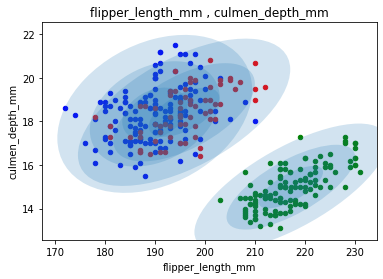

In [187]:
for first, second in zip(['culmen_length_mm', 'flipper_length_mm', 'body_mass_g', 'flipper_length_mm']
                         ,['culmen_depth_mm', 'culmen_length_mm', 'flipper_length_mm', 'culmen_depth_mm']):
    for color, label in zip(['blue', 'red', 'green'], ['Adelie', 'Chinstrap', 'Gentoo']):
        X = data.loc[data.species == label]
        X = X.loc[:, [first, second]]
        X = np.array(X)
        clf = mixture.GaussianMixture(n_components=1, covariance_type='full')
        clf.fit(X)
        labels = clf.predict(X)
        plt.scatter(X[:, 0], X[:, 1], c=color, s=20)
        print("Means: ", clf.means_, "Covariances: ", clf.covariances_, "Weights: ", clf.weights_)
        w_factor = 0.2 / clf.weights_.max()
        for pos, covar, w in zip(clf.means_, clf.covariances_, clf.weights_):
            draw_ellipse(pos, covar, alpha=w * w_factor)
    plt.xlabel(first)
    plt.ylabel(second)
    plt.title(first + ' , ' + second)
    ax.legend(loc="lower left")
    plt.show()

The final step is to find the optimu number of components for GMMs. One way was to use cross validation and predict using a mux and choosing class with the maximum posterior probability per each datapoint and decide using accuracy and other metrics but in this question we use 2 classical metrics called AIC and BIC. I plotted AIC and BIC regarding number of components for each class. It looks like that 3 and 4 components have better performances. 4 components is the best one regarding plots.

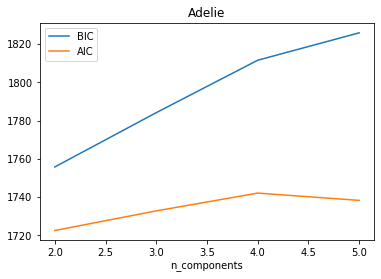

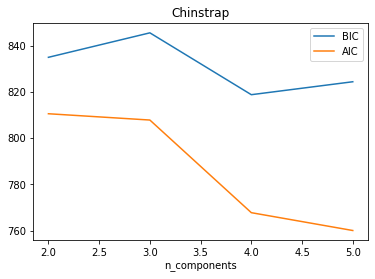

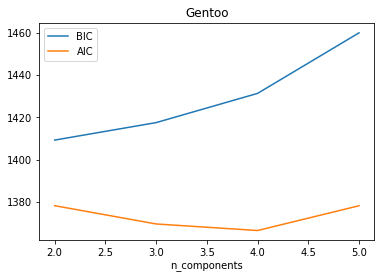

In [196]:
n_components = np.arange(2, 6)
X = data.loc[:, ['culmen_length_mm', 'flipper_length_mm']]
X = X.loc[data.species == 'Adelie']
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(X)
          for n in n_components]
plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.title('Adelie')
plt.show()
X = data.loc[:, ['culmen_length_mm', 'flipper_length_mm']]
X = X.loc[data.species == 'Chinstrap']
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(X)
          for n in n_components]
plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.title('Chinstrap')
plt.show()
X = data.loc[:, ['culmen_length_mm', 'flipper_length_mm']]
X = X.loc[data.species == 'Gentoo']
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(X)
          for n in n_components]
plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.title('Gentoo')
plt.show()